In [1]:
# organize imports
import os
import glob
import warnings
import numpy as np
import cv2
import mahotas
import h5py
from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.externals import joblib
from sklearn.metrics import accuracy_score

In [2]:
# fixed-sizes for image
fixed_size = tuple((500, 500))

# path to training data
train_path = os.path.join("dataset", "train")

# no.of.trees for Random Forests
num_trees = 100

# bins for histogram
bins = 8

# train_test_split size
test_size = 0.10

# seed for reproducing same results
seed = 9

## Global feature descriptors

Image moments capture information about the shape of a blob in a binary image because they contain information about the intensity $I(x,y)$, as well as position $x$ and $y$ of the pixels. Hu Moments (or rather Hu moment invariants) are a set of 7 numbers calculated using central moments that are invariant to image transformations. The first 6 moments have been proved to be invariant to translation, scale, and rotation, and reflection. While the 7th moment’s sign changes for image reflection.

In [3]:
def fd_hu_moments(image):
    """
    Feature descriptor 1: Hu Moments for shape
    """
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    feature = cv2.HuMoments(cv2.moments(image)).flatten()
    return feature

The co-occurrence matrix can measure the texture of the image. Because co-occurrence matrices are typically large and sparse, various metrics of the matrix are often taken to get a more useful set of features. Features generated using this technique are usually called Haralick features.

In [4]:
def fd_haralick(image):
    """ 
    Feature descriptor 2: Haralick Texture for surface texture
    """
    # convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # compute the haralick texture feature vector
    haralick = mahotas.features.haralick(gray).mean(axis=0)
    # return the result
    return haralick

In [5]:
def fd_histogram(image, mask=None):
    """ 
    Feature descriptor 3: Color histogram for color
    """
    # convert the image to HSV color-space
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    # compute the color histogram
    hist = cv2.calcHist(
        [image], [0, 1, 2], None, [bins, bins, bins], [0, 256, 0, 256, 0, 256]
        )
    # normalize the histogram
    cv2.normalize(hist, hist)
    # return the histogram
    return hist.flatten()

In [6]:
# get the training labels
train_labels = os.listdir(train_path)

# sort the training labels
train_labels.sort()

# empty lists to hold feature vectors and labels
global_features = list()
labels = list()

# loop over the training data sub-folders
for training_name in tqdm(train_labels):
    # join the training data path and each species training folder
    dir = os.path.join(train_path, training_name)
    for file in glob.glob(os.path.join(dir, "*.jpg")):
        current_label = training_name
        # read the image and resize it to a fixed-size
        image = cv2.imread(file)
        image = cv2.resize(image, fixed_size)
        # global feature extraction
        fv_hu_moments = fd_hu_moments(image)
        fv_haralick = fd_haralick(image)
        fv_histogram = fd_histogram(image)
        global_feature = np.hstack([fv_histogram, fv_haralick, fv_hu_moments])
        # update the list of labels and feature vectors
        labels.append(current_label)
        global_features.append(global_feature)

    #print("[STATUS] processed folder: {}".format(current_label))

print("[STATUS] completed Global Feature Extraction...")


# get the overall feature vector size
print(
    "[STATUS] feature vector size {}".format(np.array(global_features).shape)
    )

# get the overall training label size
print("[STATUS] training Labels {}".format(np.array(labels).shape))

100%|██████████| 17/17 [01:41<00:00,  6.41s/it]

[STATUS] completed Global Feature Extraction...
[STATUS] feature vector size (1360, 532)
[STATUS] training Labels (1360,)


In [7]:
# encode the target labels
targetNames = np.unique(labels)
le = LabelEncoder()
target = le.fit_transform(labels)
print("[STATUS] training labels encoded...")


# normalize the feature vector in the range (0-1)
scaler = MinMaxScaler(feature_range=(0, 1))
rescaled_features = scaler.fit_transform(global_features)
print("[STATUS] feature vector normalized...")

print("[STATUS] target labels: {}".format(target))
print("[STATUS] target labels shape: {}".format(target.shape))

# save the feature vector using HDF5
h5f_data = h5py.File(os.path.join("output", "data.h5"), "w")
h5f_data.create_dataset('dataset_1', data=np.array(rescaled_features))

h5f_label = h5py.File(os.path.join("output", "labels.h5"), 'w')
h5f_label.create_dataset('dataset_1', data=np.array(target))

h5f_data.close()
h5f_label.close()

print("[STATUS] end of feature extraction..")


[STATUS] training labels encoded...
[STATUS] feature vector normalized...
[STATUS] target labels: [ 0  0  0 ... 16 16 16]
[STATUS] target labels shape: (1360,)
[STATUS] end of feature extraction..


# Train models
Create a pipline with multiple machine learning models

In [8]:
# path to training data
train_path = os.path.join("dataset", "train")

models = []
models.append(('LR', LogisticRegression(random_state=seed)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier(random_state=seed)))
models.append(
    ('RF', RandomForestClassifier(n_estimators=num_trees, random_state=seed)))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(random_state=seed)))

# variables to hold the results and names
results = []
names = []
scoring = "accuracy"

# import the feature vector and trained labels
h5f_data = h5py.File(os.path.join("output/data.h5"), "r")
h5f_label = h5py.File(os.path.join("output","labels.h5"), 'r')

global_features_string = h5f_data['dataset_1']
global_labels_string = h5f_label['dataset_1']

global_features = np.array(global_features_string)
global_labels = np.array(global_labels_string)

h5f_data.close()
h5f_label.close()

In [9]:
# verify the shape of the feature vector and labels
print("[STATUS] features shape: {}".format(global_features.shape))
print("[STATUS] labels shape: {}".format(global_labels.shape))

print("[STATUS] training started...")

# split the training and testing data
test_size = 0.1
(trainDataGlobal, testDataGlobal, trainLabelsGlobal, testLabelsGlobal) = train_test_split(np.array(global_features),
                                                                                          np.array(global_labels),
                                                                                          test_size=test_size,
                                                                                          random_state=seed)

print("[STATUS] splitted train and test data...")
print("Train data  : {}".format(trainDataGlobal.shape))
print("Test data   : {}".format(testDataGlobal.shape))
print("Train labels: {}".format(trainLabelsGlobal.shape))
print("Test labels : {}".format(testLabelsGlobal.shape))

# filter all the warnings
warnings.filterwarnings('ignore')

# 10-fold cross validation
for name, model in models:
    kfold = KFold(n_splits=10, random_state=7)
    cv_results = cross_val_score(
        model, trainDataGlobal, trainLabelsGlobal, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "{}: {} ({})".format(name, cv_results.mean(), cv_results.std())
    print(msg)

[STATUS] features shape: (1360, 532)
[STATUS] labels shape: (1360,)
[STATUS] training started...
[STATUS] splitted train and test data...
Train data  : (1224, 532)
Test data   : (136, 532)
Train labels: (1224,)
Test labels : (136,)
LR: 0.5082700253232041 (0.03603328903064615)
LDA: 0.4363787818206051 (0.032834136483966714)
KNN: 0.3554244968679195 (0.028966661882888375)
CART: 0.44284286285485813 (0.05935905261564917)
RF: 0.6585565773690524 (0.052457482855030206)
NB: 0.3782753565240571 (0.03774870682260341)
SVM: 0.0507130481140877 (0.03419887175438972)


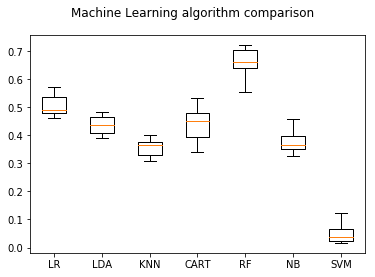

In [10]:
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Machine Learning algorithm comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.savefig("algo_compare")

What is good performance?

In [11]:
baseline = np.random.choice(list(set(trainLabelsGlobal)), size=len(trainLabelsGlobal))

baseline_accuracy = 0
k = 10
for i in range(k):
    baseline_accuracy += accuracy_score(trainLabelsGlobal, baseline, normalize=True)

baseline_accuracy = round(baseline_accuracy/k, 2)
print("Accurracy in random classifier for {} iterations: {}".format(k, baseline_accuracy))

Accurracy in random classifier for 10 iterations: 0.05


## Application of best classifier

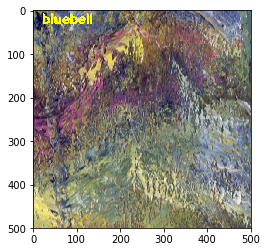

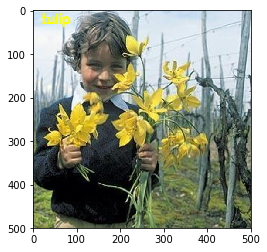

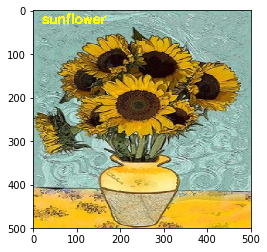

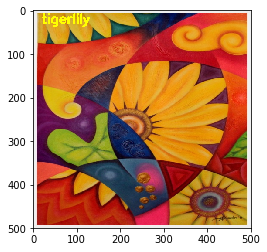

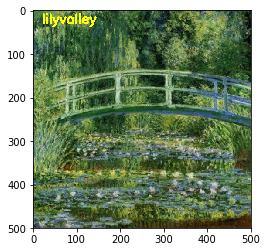

In [17]:
# create the model - Random Forests
clf = RandomForestClassifier(n_estimators=100, random_state=9)

# fit the training data to the model
clf.fit(trainDataGlobal, trainLabelsGlobal)

# path to test data
test_path = os.path.join("dataset","test")
# get the training labels
train_labels = os.listdir(train_path)


# sort the training labels
train_labels.sort()

# loop through the test images
for file in glob.glob(os.path.join(test_path,"*.jpg")):
    # read the image
    image = cv2.imread(file)

    # resize the image
    image = cv2.resize(image, fixed_size)

    # global Feature extraction
    fv_hu_moments = fd_hu_moments(image)
    fv_haralick = fd_haralick(image)
    fv_histogram = fd_histogram(image)

    # concatenate global features
    global_feature = np.hstack([fv_histogram, fv_haralick, fv_hu_moments])

    # predict label of test image
    prediction = clf.predict(global_feature.reshape(1, -1))[0]

    # show predicted label on image
    cv2.putText(
        image, train_labels[prediction], (20, 30), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 255, 255), 3)

    # display the output image
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()
    #plt.savefig("predict_" + file.split("/")[-1] + ".png")
    #plt.close()